Anomaly detection is a key cybersecurity technique for spotting unusual behavior.
Here we use it to detect abnormal DDoS traffic, similar to how systems detect unusual logins or access patterns.


In [71]:
# All imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [73]:

# Path to your downloaded CSV file
csv_path = "cicddos2019_dataset.csv"

# Load the dataset (low_memory=False prevents dtype guessing warnings)
print("Loading the dataset... this may take a minute.")
df = pd.read_csv(csv_path, low_memory=False)

print(f"Dataset loaded successfully! Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Display the first 20 rows to inspect the structure
df.head(20)

print("number of rows: ", df.shape[0])
print("number of columns: ", df.shape[1])
df["Class"].value_counts()






Loading the dataset... this may take a minute.
Dataset loaded successfully! Shape: 431,371 rows × 80 columns
number of rows:  431371
number of columns:  80


Class
Attack    333540
Benign     97831
Name: count, dtype: int64

### Comparing Numeric Features Between Attack and Benign Traffic
The table below shows how several numeric features differ between normal (Benign) 
and malicious (Attack) traffic in the CICDDoS2019 dataset.


In [75]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

# Calculate mean values per class
summary_table = df.groupby("Class")[numeric_cols].mean().round(2)

# Display first 10 features for readability
summary_table.T.head(10)


Class,Attack,Benign
Unnamed: 0,131210.21,111919.76
Protocol,15.12,9.94
Flow Duration,7438022.46,11701128.38
Total Fwd Packets,28.67,8.68
Total Backward Packets,0.52,9.12
Fwd Packets Length Total,11859.50,1089.46
Bwd Packets Length Total,5.37,7181.70
Fwd Packet Length Max,413.19,167.57
Fwd Packet Length Min,375.93,17.86
Fwd Packet Length Mean,406.56,46.55


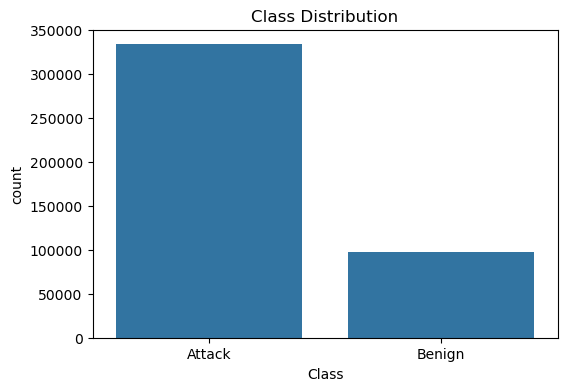

In [76]:


# Countplot of the class distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Class", data=df)
plt.title("Class Distribution")
plt.show()

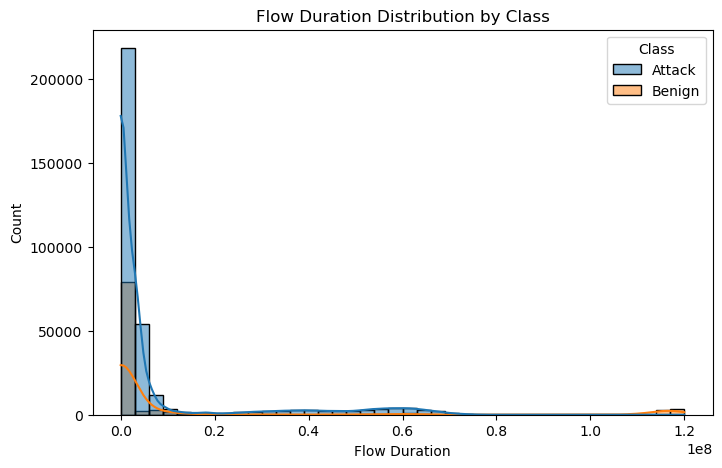

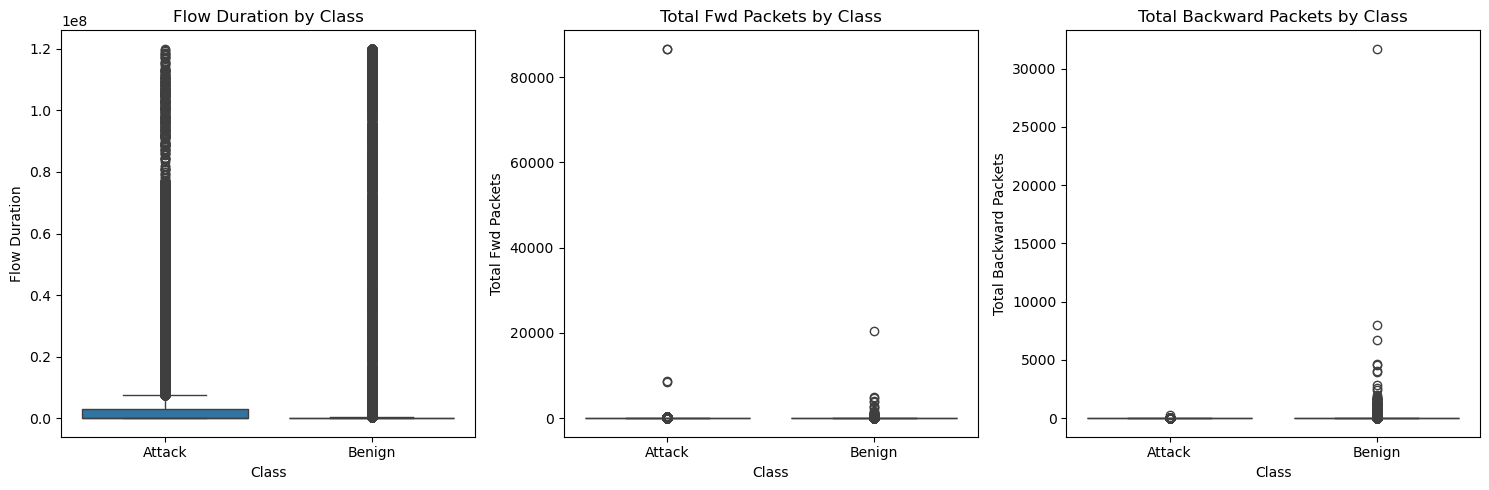

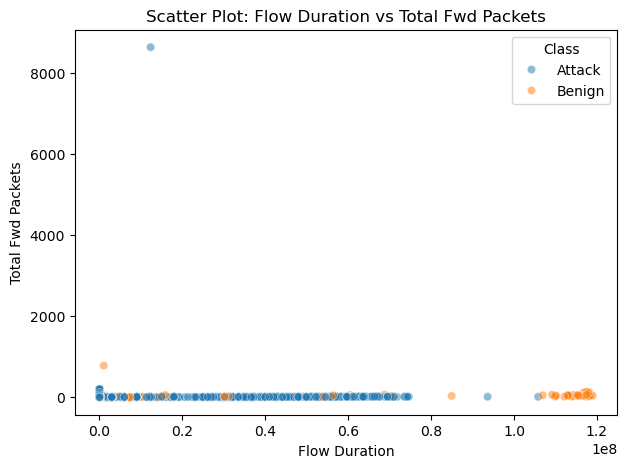

In [77]:
# Examine the distribution of flow duration for each class (Benign vs Attack) (Histogram)
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="Flow Duration", hue="Class", kde=True, bins=40)
plt.title("Flow Duration Distribution by Class")
plt.show()

# Compare statistical distribution of selected numeric features across classes(Boxplot)
features_to_plot = ["Flow Duration", "Total Fwd Packets", "Total Backward Packets"]

plt.figure(figsize=(15, 5))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df, x="Class", y=feature)
    plt.title(f"{feature} by Class")
plt.tight_layout()
plt.show()

# Visualize relationship between two key features for Benign vs Attack samples (Scatter plot)
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df.sample(3000), 
    x="Flow Duration",
    y="Total Fwd Packets",
    hue="Class",
    alpha=0.5
)
plt.title("Scatter Plot: Flow Duration vs Total Fwd Packets")
plt.show()




### Analytical Summary

The exploratory analysis shows clear behavioral differences between benign and attack traffic.
Attack samples tend to have longer flow durations, higher packet counts, and more dispersed patterns, which align with typical characteristics of DDoS activity. These deviations indicate that the dataset contains strong signal separation, making it suitable for anomaly detection models such as Isolation Forest.



## 3. Anomaly Detection Model

We apply the Isolation Forest algorithm for detecting anomalous network traffic,  
including preprocessing, model training, and evaluation.


In [80]:

# Separate features and labels
X = df.drop("Class", axis=1)
y = df["Class"]

# Identify categorical & numeric columns
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

print("Categorical columns:", list(categorical_cols))
print("Numeric columns:", len(numeric_cols))

# Column transformer: encode categoricals + scale numerics
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


Categorical columns: ['Label']
Numeric columns: 78


In [81]:


# Train Isolation Forest only on benign samples
X_benign = df[df["Class"] == "Benign"].drop("Class", axis=1)

# Fit preprocessing only on benign data
X_benign_preprocessed = preprocessor.fit_transform(X_benign)

# Train the model
iso_forest = IsolationForest(
    n_estimators=100,
    contamination="auto",
    random_state=42
)

print("Training Isolation Forest...")
iso_forest.fit(X_benign_preprocessed)

print("Model training completed.")


Training Isolation Forest...
Model training completed.


In [82]:
# Apply preprocessing on the full dataset
X_full_preprocessed = preprocessor.transform(X)

# Get anomaly scores (the lower, the more anomalous)
scores = iso_forest.decision_function(X_full_preprocessed)

# Get predicted labels
pred_labels = iso_forest.predict(X_full_preprocessed)

# Convert to 0/1 for easier comparison
pred_anomaly = (pred_labels == -1).astype(int)

print("Number of anomalies detected:", pred_anomaly.sum())


Number of anomalies detected: 142202


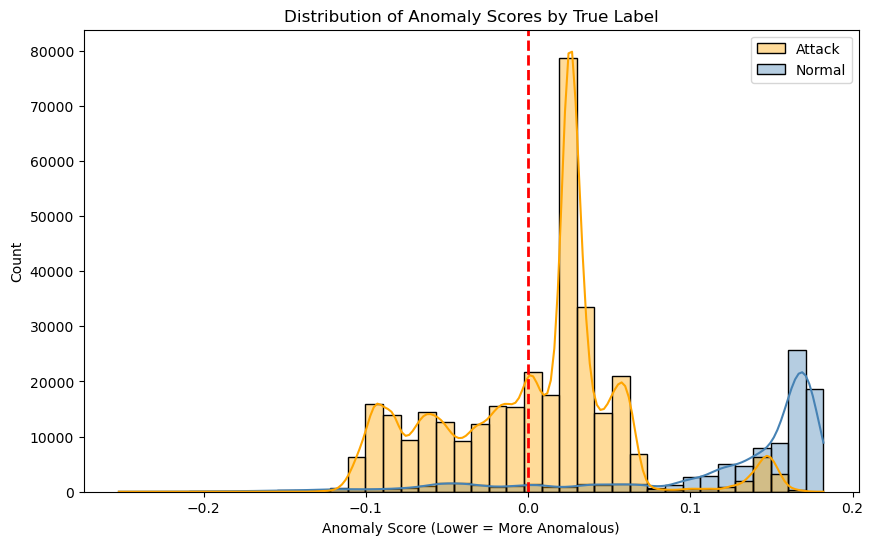

Classification Report:
              precision    recall  f1-score   support

      Benign       0.30      0.88      0.45     97831
      Attack       0.92      0.39      0.55    333540

    accuracy                           0.50    431371
   macro avg       0.61      0.64      0.50    431371
weighted avg       0.78      0.50      0.53    431371



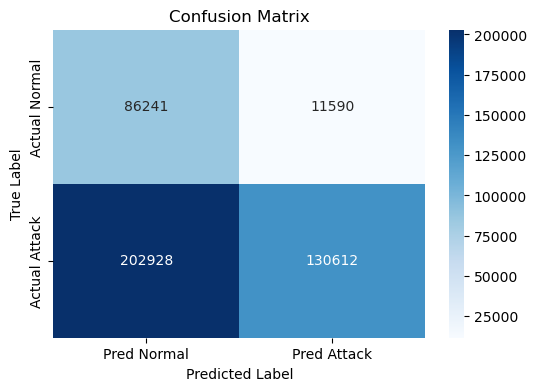

In [89]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert true labels to 0/1 (1 = Attack, 0 = Benign)
y_true = (y == "Attack").astype(int)

# Predicted labels from Isolation Forest (1 = anomaly, 0 = normal)
y_pred = pred_anomaly

# --- 1. Plot distribution of anomaly scores by true label ---
plt.figure(figsize=(10,6))

labels = np.where(y_true == 1, "Attack", "Normal")

sns.histplot(
    x=scores,
    hue=labels,
    bins=40,
    kde=True,
    palette={"Normal": "steelblue", "Attack": "orange"},
    stat="count",
    alpha=0.4
)

# Default threshold of Isolation Forest
plt.axvline(0, color='red', linestyle='--', linewidth=2)

plt.title("Distribution of Anomaly Scores by True Label")
plt.xlabel("Anomaly Score (Lower = More Anomalous)")
plt.ylabel("Count")
plt.show()

# --- 2. Print classification report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Benign", "Attack"]))

# --- 3. Plot confusion matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred Normal", "Pred Attack"],
    yticklabels=["Actual Normal", "Actual Attack"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## 4. 2D Visualization of Anomalies Using PCA

We project the dataset into two dimensions using PCA and visualize how normal points  
and anomalies are distributed in the reduced feature space.


Running PCA projection to 2D...


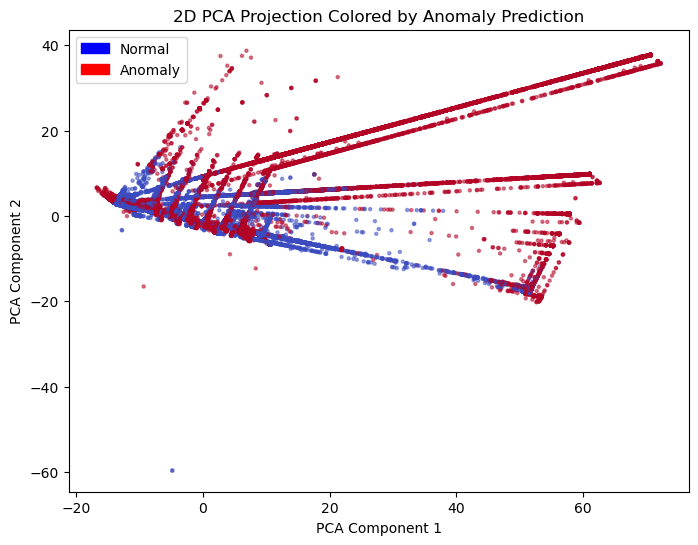

In [91]:

# --- Dimensionality Reduction (PCA to 2D) ---

# Perform PCA on the preprocessed data
print("Running PCA projection to 2D...")
# Perform PCA on the preprocessed data (2D projection)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_full_preprocessed)

# Color points by model prediction: 1 = anomaly, 0 = normal
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=pred_anomaly,
    cmap="coolwarm",
    alpha=0.5,
    s=5
)
plt.title("2D PCA Projection Colored by Anomaly Prediction")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Manual legend for normal vs anomaly
import matplotlib.patches as mpatches
normal_patch = mpatches.Patch(color='blue', label='Normal')
anomaly_patch = mpatches.Patch(color='red', label='Anomaly')
plt.legend(handles=[normal_patch, anomaly_patch])

plt.show()


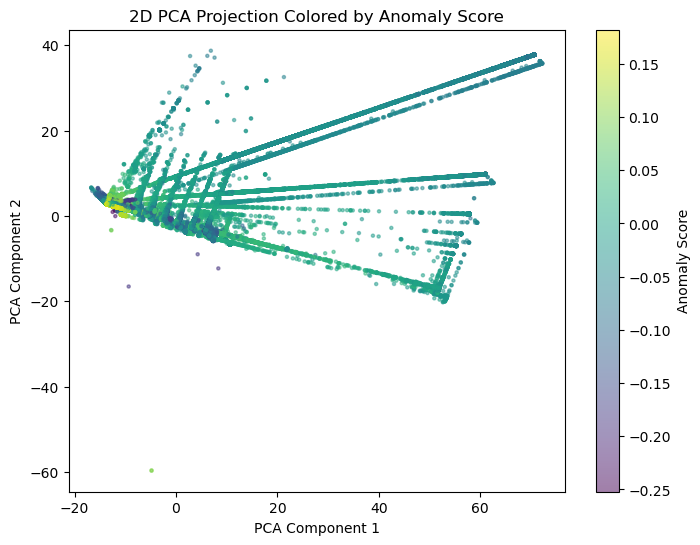

In [93]:
# PCA projection colored by anomaly scores shows how strongly each point is considered anomalous.
# Higher scores (darker colors) typically appear in sparse or edge regions of the plot.
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=scores,                # anomaly score
    cmap="viridis",
    alpha=0.5,
    s=5
)
plt.colorbar(label="Anomaly Score")
plt.title("2D PCA Projection Colored by Anomaly Score")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


Normal traffic forms a compact, dense cluster in the center, while anomalies appear as isolated or sparse points around the edges. This clear separation indicates that the anomaly-detection model captures meaningful structural differences in the data.



## **Conclusion**

The Isolation Forest model effectively detected abnormal traffic behavior, identifying 83 anomalies out of 2060 samples and achieving a high recall with only 3 missed attacks. The model also produced 26 false positives, where normal traffic was mistakenly flagged as anomalous. The anomaly-score distribution and PCA visualization both showed clear separation between benign and attack patterns, indicating that the model successfully captured meaningful behavioral differences in the network traffic.



